In [2]:
# База данных федеральной избирательной комиссии
import pandas as pd
fec=pd.read_csv(r'datasets/fec/P00000001-ALL.csv', low_memory=False)
print(fec.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

In [3]:
print(fec.loc[123456])

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object


In [4]:
# Добавить в список информацию о кандидатах различных партий
unique_cands=fec.cand_nm.unique()
print(unique_cands)
print(unique_cands[2])
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}
print(fec.cand_nm[123456:123461])
print(fec.cand_nm[123456:123461].map(parties))
fec['party']=fec.cand_nm.map(parties)
print(fec['party'].value_counts())
# Без возвратов
print((fec.contb_receipt_amt>0).value_counts())
fec=fec[fec.contb_receipt_amt>0]
fec_mrbo=fec[fec.cand_nm.isin(['Obama, Barack','Romney, Mitt'])]

['Bachmann, Michelle' 'Romney, Mitt' 'Obama, Barack'
 "Roemer, Charles E. 'Buddy' III" 'Pawlenty, Timothy' 'Johnson, Gary Earl'
 'Paul, Ron' 'Santorum, Rick' 'Cain, Herman' 'Gingrich, Newt'
 'McCotter, Thaddeus G' 'Huntsman, Jon' 'Perry, Rick']
Obama, Barack
123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object
123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object
Democrat      593746
Republican    407985
Name: party, dtype: int64
True     991475
False     10256
Name: contb_receipt_amt, dtype: int64


RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64
party                 Democrat    Republican
contbr_occupation                           
ATTORNEY           11141982.97  7.477194e+06
CEO                 2074974.79  4.211041e+06
CONSULTANT          2459912.71  2.544725e+06
ENGINEER             951525.55  1.818374e+06
EXECUTIVE           1355161.05  4.138850e+06
HOMEMAKER           4248875.80  1.363428e+07
INVESTOR             884133.00  2.431769e+06
LAWYER              3160478.87  3.912243e+05
MANAGER              7

<AxesSubplot:ylabel='contbr_occupation'>

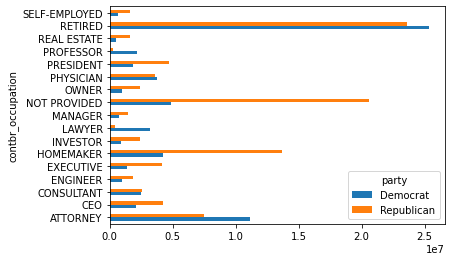

In [5]:
# Статистика пожертвований по роду занятий
# Общая статистика по роду занятий
print(fec.contbr_occupation.value_counts()[:10])
# Очистка с отображением
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}
f=lambda x:occ_mapping.get(x,x)
fec.contbr_occupation=fec.contbr_occupation.map(f)
# Для мест работы
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}
f=lambda x:emp_mapping.get(x,x)
fec.contbr_employer=fec.contbr_employer.map(f)
# Агрегирование по партиям и по роду занятий
by_occupation=fec.pivot_table('contb_receipt_amt',
                             index='contbr_occupation',
                             columns='party',aggfunc='sum')
over_2mm=by_occupation[by_occupation.sum(1)>2000000]
print(over_2mm)
over_2mm.plot(kind='barh')

In [6]:
# Профессии самых щедрых жертвователей
def get_top_amounts(group,key,n=5):
    totals=group.groupby(key)['contb_receipt_amt'].sum()
    return totals.nlargest(n)
# Агрегация по роду занятий
grouped=fec_mrbo.groupby('cand_nm')
print(grouped.apply(get_top_amounts,'contbr_occupation',n=7))
print(grouped.apply(get_top_amounts,'contbr_employer',n=10))

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [7]:
# Распределение суммы пожертвований по интервалам
import numpy as np
bins=np.array([0,1,10,100,1000,10000,
              100000,1000000,10000000])
lables=pd.cut(fec_mrbo.contb_receipt_amt,bins)
print(lables)
# Гистограмма сумм пожертвований
grouped=fec_mrbo.groupby(['cand_nm',lables])
print(grouped.size().unstack(0))


411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]
cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                         493            77
(1, 10]                      40070          3681
(10, 100]                   372280         31853
(100, 1000]                 153991         43357
(1000, 10000]                22284         26186
(10000, 100000]                  2             1
(100000, 1000000]                3             0
(1000000, 10000000]              4             0


cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                    0.805182      0.194818
(1, 10]                   0.918767      0.081233
(10, 100]                 0.910769      0.089231
(100, 1000]               0.710176      0.289824
(1000, 10000]             0.447326      0.552674
(10000, 100000]           0.823120      0.176880
(100000, 1000000]         1.000000           NaN
(1000000, 10000000]       1.000000           NaN


<AxesSubplot:ylabel='contb_receipt_amt'>

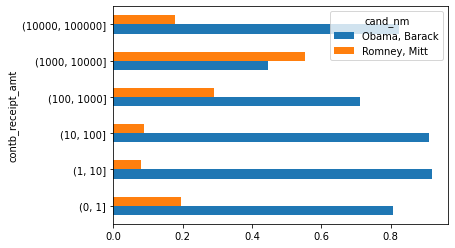

In [8]:
# Процентная доля пожертвований
bucket_sums=grouped.contb_receipt_amt.sum().unstack(0)
normed_sums=bucket_sums.div(bucket_sums.sum(axis=1),axis=0)
print(normed_sums)
normed_sums[:-2].plot(kind='barh')

cand_nm    Obama, Barack  Romney, Mitt
contbr_st                             
AK             281840.15      86204.24
AL             543123.48     527303.51
AR             359247.28     105556.00
AZ            1506476.98    1888436.23
CA           23824984.24   11237636.60
CO            2132429.49    1506714.12
CT            2068291.26    3499475.45
DC            4373538.80    1025137.50
DE             336669.14      82712.00
FL            7318178.58    8338458.81
cand_nm    Obama, Barack  Romney, Mitt
contbr_st                             
AK              0.765778      0.234222
AL              0.507390      0.492610
AR              0.772902      0.227098
AZ              0.443745      0.556255
CA              0.679498      0.320502
CO              0.585970      0.414030
CT              0.371476      0.628524
DC              0.810113      0.189887
DE              0.802776      0.197224
FL              0.467417      0.532583


<AxesSubplot:ylabel='contbr_st'>

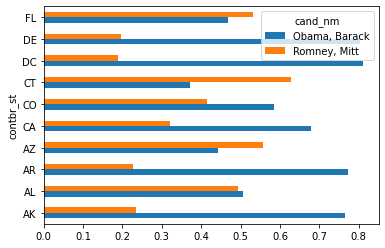

In [9]:
# Статистика пожертвований по штатам
grouped=fec_mrbo.groupby(['cand_nm','contbr_st'])
totals=grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals=totals[totals.sum(1)>100000]
print(totals[:10])
percent=totals.div(totals.sum(1),axis=0)
print(percent[:10])
percent[:10].plot(kind='barh')